# <font color=#025dfa> 2 Farklı Yolla Kitaplar Öneri Sistemi ve Derin Öğrenme - Kitaplar Recommendation System and Deep Learning in 2 Different Ways

TR = Her yorum satırı kendisini üstündeki koda aittir. İlk olarak Türkçe, son olarak İngilizce yazıldı.

EN = Each comment line belongs to the code above it. It was first written in Turkish and lastly in English.

TR = Bu proje, kitap öneri sistemlerini geliştirmek amacıyla çeşitli yöntemleri bir araya getirmeyi hedeflemektedir. Popülerlik tabanlı öneriler, ve K-en yakın komşular algoritması ve derin öğrenme teknikleri kullanılarak, kullanıcılara daha kişiselleştirilmiş ve doğru kitap önerileri sunulacaktır. Proje, kitap seçimlerini iyileştirmek ve kullanıcıların ilgilerini daha iyi yansıtacak öneriler sağlamak için bu yöntemlerin entegrasyonunu sağlayarak, kitap öneri sistemlerinin etkinliğini ve kullanıcı memnuniyetini artırmayı amaçlamaktadır.

EN = This project aims to combine various methods to improve book recommendation systems. By using popularity-based recommendations, and K-nearest neighbors algorithm and deep learning techniques, more personalized and accurate book recommendations will be provided to users. The project aims to increase the efficiency and user satisfaction of book recommendation systems by integrating these methods to improve book selection and provide recommendations that better reflect users' interests.

Kaynak/Source = https://thecleverprogrammer.com/2020/05/23/book-recommendation-system-with-machine-learning/

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import json
from scipy import spatial
import re
import warnings
warnings.filterwarnings('ignore')

from scipy import spatial #harital üzerindeki mesafeyi ölçüyor

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization,Flatten,LeakyReLU
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler

In [2]:
books = pd.read_csv('BX-Books.csv', sep=';', on_bad_lines='skip', encoding="latin-1")
books.columns = ['ISBN', 'bookTitle', 'bookAuthor', 'yearOfPublication', 'publisher', 'imageUrlS', 'imageUrlM', 'imageUrlL']

users = pd.read_csv('BX-Users.csv', sep=';', on_bad_lines='skip', encoding="latin-1")
users.columns = ['userID', 'Location', 'Age']

ratings = pd.read_csv('BX-Book-Ratings.csv', sep=';', on_bad_lines='skip', encoding="latin-1")
ratings.columns = ['userID', 'ISBN', 'rating']

In [3]:
books

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...
...,...,...,...,...,...,...,...,...
271355,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...
271356,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...
271357,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...
271358,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...


In [4]:
users

,userID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN
...,...,...,...
278853,278854,"portland, oregon, usa",NaN
278854,278855,"tacoma, washington, united kingdom",50.0
278855,278856,"brampton, ontario, canada",NaN
278856,278857,"knoxville, tennessee, usa",NaN


In [5]:
ratings

,userID,ISBN,rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6
...,...,...,...
1149775,276704,1563526298,9
1149776,276706,0679447156,0
1149777,276709,0515107662,10
1149778,276721,0590442449,10


In [6]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   ISBN               271360 non-null  object
 1   bookTitle          271360 non-null  object
 2   bookAuthor         271358 non-null  object
 3   yearOfPublication  271360 non-null  object
 4   publisher          271358 non-null  object
 5   imageUrlS          271360 non-null  object
 6   imageUrlM          271360 non-null  object
 7   imageUrlL          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [7]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   userID    278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column  Non-Null Count    Dtype 
---  ------  --------------    ----- 
 0   userID  1149780 non-null  int64 
 1   ISBN    1149780 non-null  object
 2   rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [9]:
books.iloc[159]

ISBN                                                        0061030147
bookTitle            Cybill Disobedience: How I Survived Beauty Pag...
bookAuthor                                             Cybill Shepherd
yearOfPublication                                                 2001
publisher                                                   Avon Books
imageUrlS            http://images.amazon.com/images/P/0061030147.0...
imageUrlM            http://images.amazon.com/images/P/0061030147.0...
imageUrlL            http://images.amazon.com/images/P/0061030147.0...
Name: 159, dtype: object

In [10]:
users.iloc[195]

userID                                              196
Location    subang jaya, selangor darul ehsan, malaysia
Age                                                33.0
Name: 195, dtype: object

In [11]:
ratings.iloc[241]

userID        276853
ISBN      8420457477
rating             1
Name: 241, dtype: object

In [12]:
users=users.dropna()
books=books.dropna()
ratings=ratings.dropna()

In [13]:
books=books.head(10000)
users=users.head(10000)
ratings=ratings.head(10000)
# TR = Güçlü bilgisayarınız varsa bu 3 kodun önüne (#) koyabilirsiniz.
# EN = If you have a powerful computer, you can put (#) in front of these 3 codes.

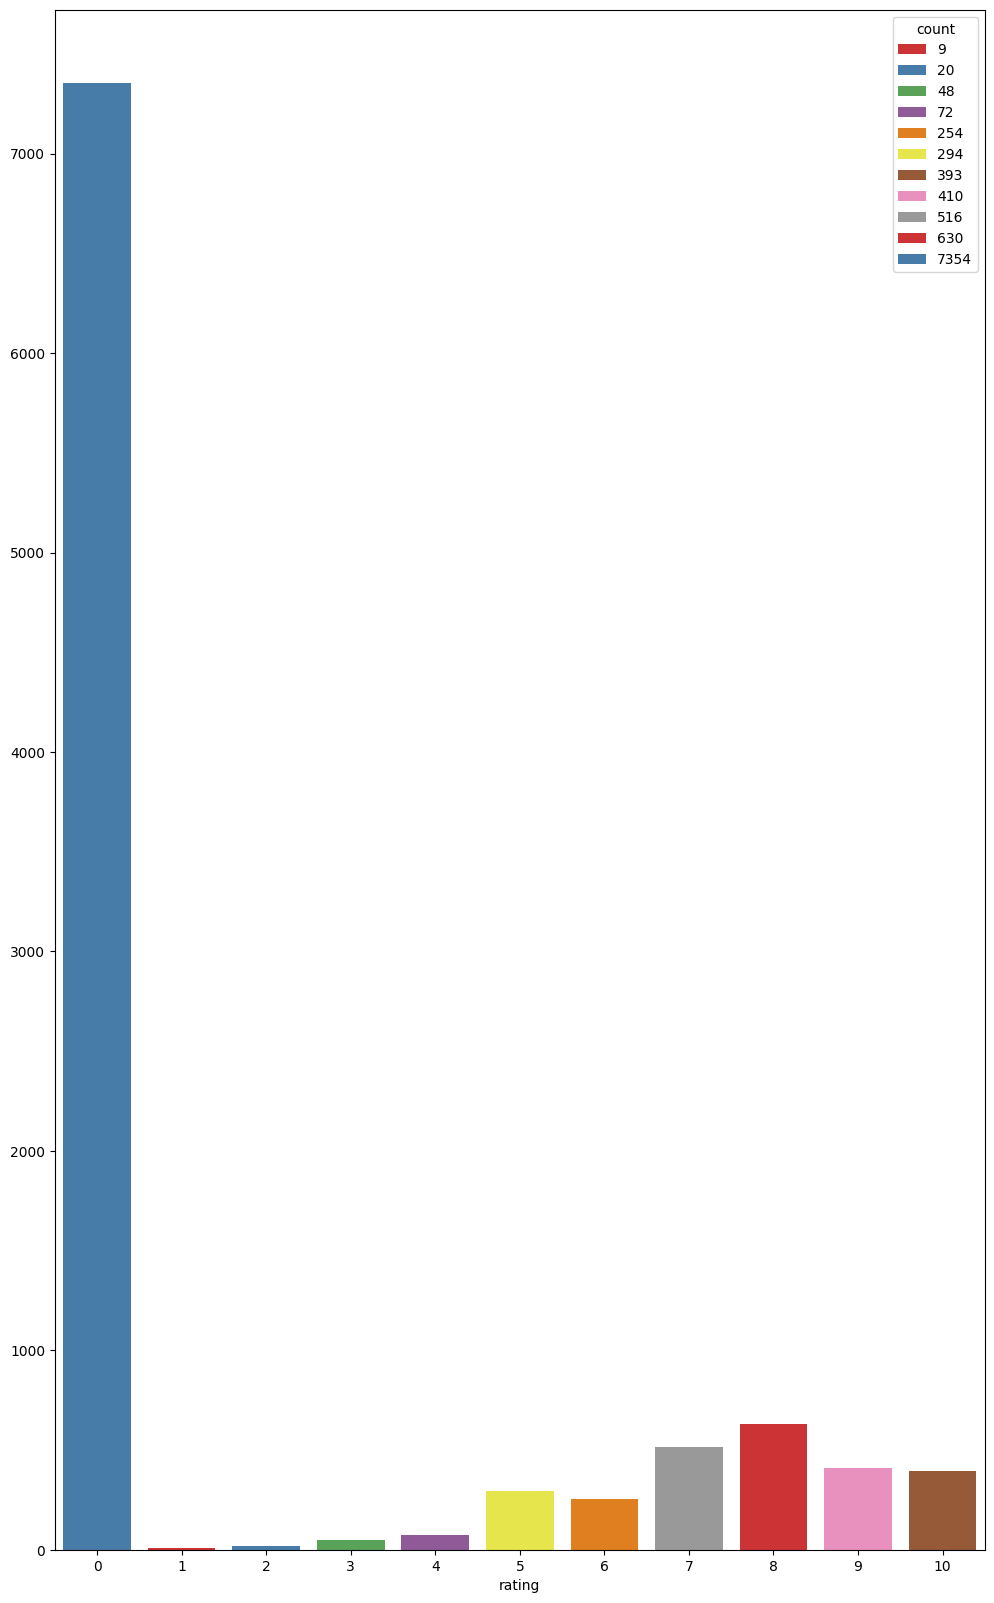

In [14]:
plt.figure(figsize=(12,20))
sns.barplot(x=ratings['rating'].value_counts().index,y=ratings['rating'].value_counts().values,hue=ratings['rating'].value_counts(),palette='Set1');

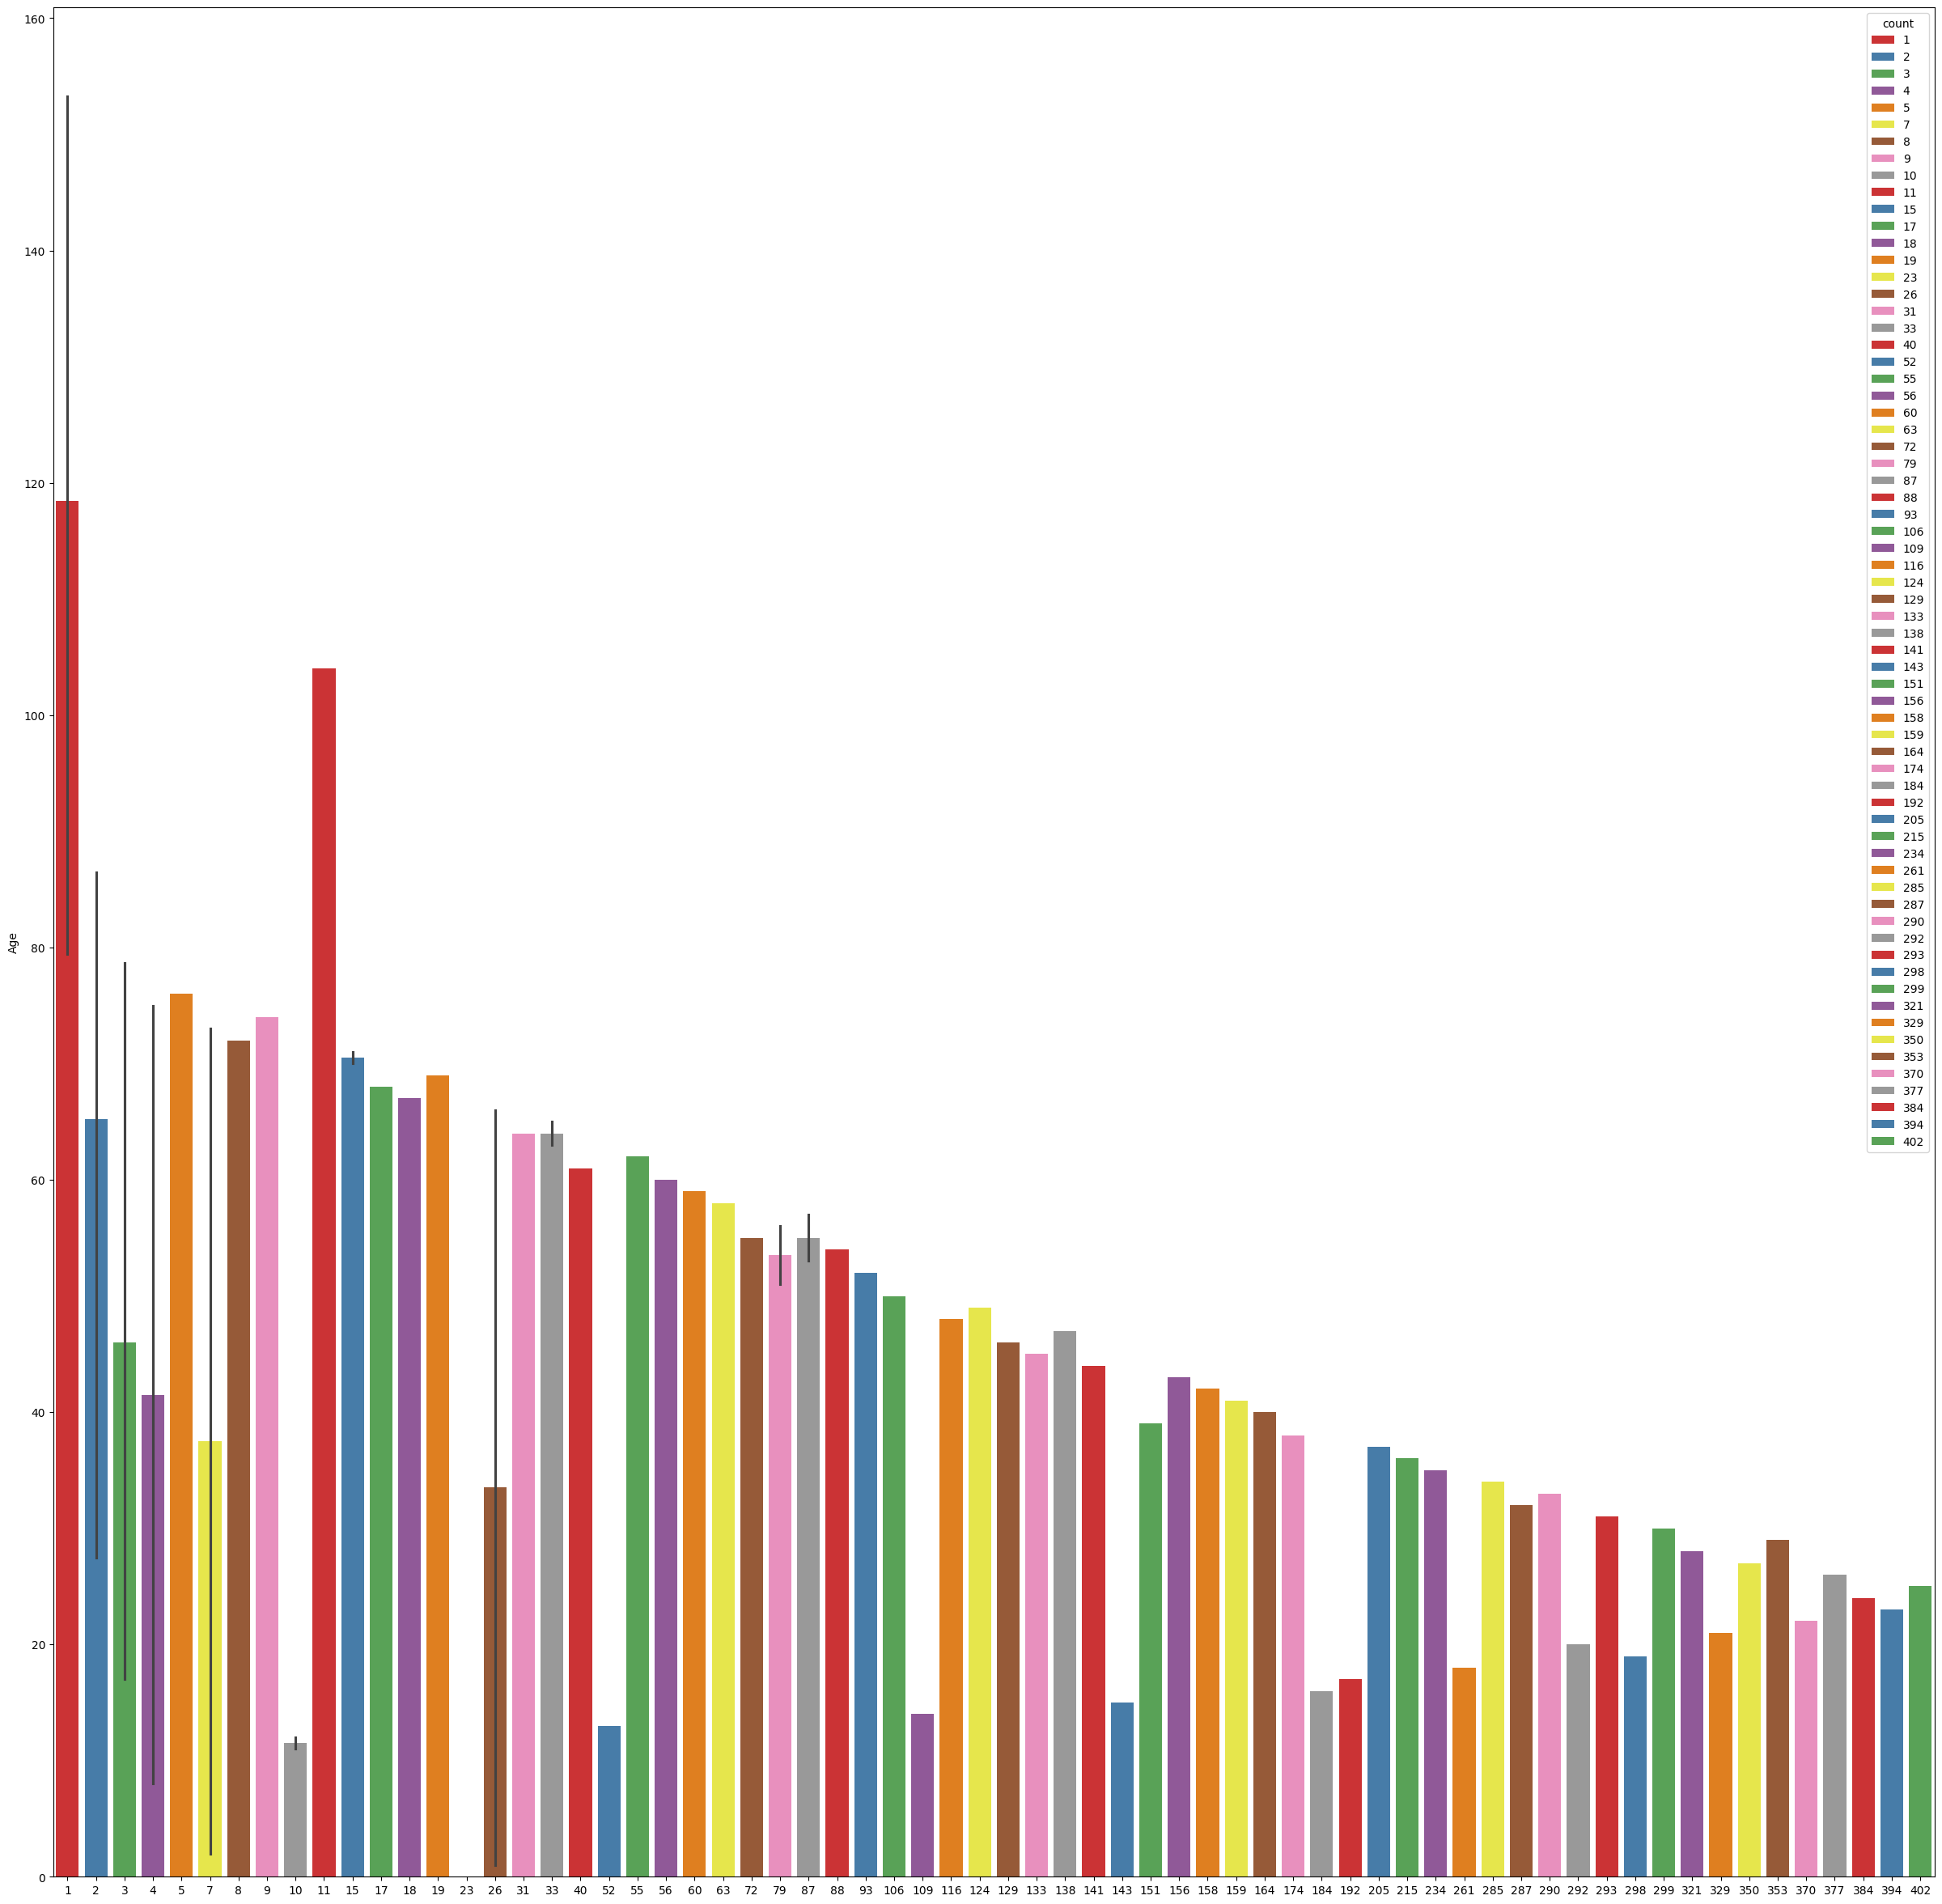

In [15]:
plt.figure(figsize=(30,30))
sns.barplot(y=users['Age'].value_counts().index,x=users['Age'].value_counts().values,hue=users['Age'].value_counts(),palette='Set1');

In [16]:
ratings_books = pd.merge(ratings, books, on='ISBN')
df = pd.merge(ratings_books, users, on='userID')
# TR = books ve ratings veri setlerini birleştiriyoruz. Varsayılan olarak ortak kolon olan 'ISBN' üzerinden birleştirme yapar.
# EN = We are merging the books and ratings datasets. By default, it merges on the common column 'ISBN'.

In [17]:
df.head()

,userID,ISBN,rating,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,Location,Age
0,99,0451166892,3,The Pillars of the Earth,Ken Follett,1996,Signet Book,http://images.amazon.com/images/P/0451166892.0...,http://images.amazon.com/images/P/0451166892.0...,http://images.amazon.com/images/P/0451166892.0...,"franktown, colorado, usa",42.0
1,99,0786868716,0,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,"franktown, colorado, usa",42.0
2,99,067976397X,0,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,http://images.amazon.com/images/P/067976397X.0...,http://images.amazon.com/images/P/067976397X.0...,http://images.amazon.com/images/P/067976397X.0...,"franktown, colorado, usa",42.0
3,99,0312252617,8,Fast Women,Jennifer Crusie,2001,St. Martin's Press,http://images.amazon.com/images/P/0312252617.0...,http://images.amazon.com/images/P/0312252617.0...,http://images.amazon.com/images/P/0312252617.0...,"franktown, colorado, usa",42.0
4,99,0312261594,8,Female Intelligence,Jane Heller,2001,St. Martin's Press,http://images.amazon.com/images/P/0312261594.0...,http://images.amazon.com/images/P/0312261594.0...,http://images.amazon.com/images/P/0312261594.0...,"franktown, colorado, usa",42.0


In [18]:
df.bookTitle.value_counts()

bookTitle
Wild Animus                                                                2
The Beach House                                                            2
The Pillars of the Earth                                                   1
The Therapeutic Touch: How to Use Your Hands to Help or to Heal            1
El Senor De Los Anillos: Las DOS Torres (Lord of the Rings (Paperback))    1
                                                                          ..
Ist mein Hintern wirklich so dick? Tagebuch einer empfindsamen Frau.       1
Die Klone der Joanna May. Roman.                                           1
Die Liebe in Den Zelten                                                    1
Veronika Deschliesst Zu Sterben / Vernika Decides to Die                   1
Always Daddy's Girl: Understanding Your Father's Impact on Who You Are     1
Name: count, Length: 124, dtype: int64

In [19]:
df.ISBN.nunique()

124

## <font color=#FFD700> Popülerliğe Dayalı - Popularity Based

In [20]:
df

,userID,ISBN,rating,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,Location,Age
0,99,0451166892,3,The Pillars of the Earth,Ken Follett,1996,Signet Book,http://images.amazon.com/images/P/0451166892.0...,http://images.amazon.com/images/P/0451166892.0...,http://images.amazon.com/images/P/0451166892.0...,"franktown, colorado, usa",42.0
1,99,0786868716,0,The Five People You Meet in Heaven,Mitch Albom,2003,Hyperion,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,http://images.amazon.com/images/P/0786868716.0...,"franktown, colorado, usa",42.0
2,99,067976397X,0,Corelli's Mandolin : A Novel,LOUIS DE BERNIERES,1995,Vintage,http://images.amazon.com/images/P/067976397X.0...,http://images.amazon.com/images/P/067976397X.0...,http://images.amazon.com/images/P/067976397X.0...,"franktown, colorado, usa",42.0
3,99,0312252617,8,Fast Women,Jennifer Crusie,2001,St. Martin's Press,http://images.amazon.com/images/P/0312252617.0...,http://images.amazon.com/images/P/0312252617.0...,http://images.amazon.com/images/P/0312252617.0...,"franktown, colorado, usa",42.0
4,99,0312261594,8,Female Intelligence,Jane Heller,2001,St. Martin's Press,http://images.amazon.com/images/P/0312261594.0...,http://images.amazon.com/images/P/0312261594.0...,http://images.amazon.com/images/P/0312261594.0...,"franktown, colorado, usa",42.0
...,...,...,...,...,...,...,...,...,...,...,...,...
121,215,0061030147,6,Cybill Disobedience: How I Survived Beauty Pag...,Cybill Shepherd,2001,Avon Books,http://images.amazon.com/images/P/0061030147.0...,http://images.amazon.com/images/P/0061030147.0...,http://images.amazon.com/images/P/0061030147.0...,"port alberni, british columbia, canada",20.0
122,228,0385337639,7,Crow Lake (Today Show Book Club #7),Mary Lawson,2003,Delta,http://images.amazon.com/images/P/0385337639.0...,http://images.amazon.com/images/P/0385337639.0...,http://images.amazon.com/images/P/0385337639.0...,"ann arbor, michigan, usa",41.0
123,228,039575514X,9,My Antonia,Willa Cather,1995,Mariner Books,http://images.amazon.com/images/P/039575514X.0...,http://images.amazon.com/images/P/039575514X.0...,http://images.amazon.com/images/P/039575514X.0...,"ann arbor, michigan, usa",41.0
124,237,0785263292,0,"If Singleness Is a Gift, What's the Return Pol...",Holly Virden,2003,Nelson Books,http://images.amazon.com/images/P/0785263292.0...,http://images.amazon.com/images/P/0785263292.0...,http://images.amazon.com/images/P/0785263292.0...,"plymouth, minnesota, usa",27.0


In [21]:
book_grouped = df.groupby('bookTitle').agg({'rating': [np.size, np.sum, np.mean]})
# TR = df veri setini 'bookTitle' sütununa göre gruplayıp, her film için 'rating' sütununda 3 farklı istatistiği hesaplıyoruz:
#     np.size ile kaç değerlendirme yapıldığını (sayısı),
#     np.sum ile toplam değerlendirme puanını,
#     np.mean ile ortalama değerlendirme puanını hesaplıyoruz.

# EN = We are grouping the df dataset by the 'bookTitle' column, and calculating 3 different statistics for the 'rating' column:
#     np.size to get the number of ratings (count),
#     np.sum to get the total rating score,
#     np.mean to get the average rating score.


In [22]:
book_grouped

rating          
                                                     size sum  mean
bookTitle                                                          
A Kiss Remembered                                       1   8   8.0
All He Ever Wanted: A Novel                             1   7   7.0
Always Daddy's Girl: Understanding Your Father'...      1   0   0.0
Angels &amp; Demons                                     1  10  10.0
Atonement : A Novel                                     1   0   0.0
...                                                   ...  ..   ...
Twenty Minute Retreats: Revive Your Spirits in ...      1   0   0.0
Ulysses (Ã?Â?bersetzg. WollschlÃ?Â¤ger). ( Neue...      1   0   0.0
Veronika Deschliesst Zu Sterben / Vernika Decid...      1   9   9.0
Whisper of Evil (Hooper, Kay. Evil Trilogy.)            1   0   0.0
Wild Animus                                             2   0   0.0

[124 rows x 3 columns]

In [23]:
populer_books = book_grouped.sort_values(('rating', 'mean'), ascending=False)
# TR = book_grouped veri setini 'rating' sütununun 'mean' (ortalama) değerine göre azalan sırayla sıralıyoruz.
#     Bu, en yüksek ortalama puana sahip kitapların en üste getirir.

# EN = We are sorting the book_grouped dataset by the 'mean' (average) value of the 'rating' column in descending order.
#     This brings the books with the highest average ratings to the top.


In [24]:
populer_books.head()

rating          
                                                     size sum  mean
bookTitle                                                          
Eine ganz normale AffÃ?Â¤re.                            1  10  10.0
Midnight in the Garden of Good and Evil: A Sava...      1  10  10.0
El Senor De Los Anillos: El Retorno Del Rey (To...      1  10  10.0
If I Ever Get Back to Georgia, I'm Gonna Nail M...      1  10  10.0
Creating Wealth : Retire in Ten Years Using All...      1  10  10.0

In [25]:
grouped_sum = book_grouped['rating']['sum'].sum()
# TR = book_grouped veri setindeki 'rating' sütununun 'sum' (toplam) değerlerini topluyoruz.
#     Bu, tüm kitaplar için toplam değerlendirme puanlarını toplar.

# EN = We are summing the 'sum' values from the 'rating' column in the book_grouped dataset.
#     This gives the total rating score across all books.

In [26]:
populer_books['percentage'] = book_grouped['rating']['sum'].div(grouped_sum) * 100
# TR = book_grouped veri setindeki her bir kitabın 'rating' sütunundaki 'sum' (toplam) değerini, grouped_sum (tüm kitapların toplam değerlendirme puanı) ile bölüyoruz.
#     Sonucu 100 ile çarparak, her kitabın toplam değerlendirme puanının tüm kitapların arasındaki yüzdesini hesaplıyoruz.

# EN = We are dividing the 'sum' (total) value from the 'rating' column in the book_grouped dataset by grouped_sum (the total rating score for all books).
#     We multiply the result by 100 to calculate the percentage of each book's total rating score relative to the total across all books.


In [27]:
populer_books.head()

rating           percentage
                                                     size sum  mean           
bookTitle                                                                     
Eine ganz normale AffÃ?Â¤re.                            1  10  10.0   1.730104
Midnight in the Garden of Good and Evil: A Sava...      1  10  10.0   1.730104
El Senor De Los Anillos: El Retorno Del Rey (To...      1  10  10.0   1.730104
If I Ever Get Back to Georgia, I'm Gonna Nail M...      1  10  10.0   1.730104
Creating Wealth : Retire in Ten Years Using All...      1  10  10.0   1.730104

In [28]:
populer_books = populer_books.sort_values('percentage', ascending=False)
# TR = populer_books veri setini 'percentage' sütununa göre azalan sırayla sıralıyoruz.
#     Bu, en yüksek yüzdelik değere sahip kitapları en üste getirir.
# EN = We are sorting the populer_books dataset by the 'percentage' column in descending order.
#     This brings the books with the highest percentage values to the top.

In [29]:
populer_books

rating           percentage
                                                     size sum  mean           
bookTitle                                                                     
The Beach House                                         2  14   7.0   2.422145
Eine ganz normale AffÃ?Â¤re.                            1  10  10.0   1.730104
Die Liebe in Den Zelten                                 1  10  10.0   1.730104
The Adventures of Drew and Ellie: The Magical D...      1  10  10.0   1.730104
Angels &amp; Demons                                     1  10  10.0   1.730104
...                                                   ...  ..   ...        ...
Chocolate Jesus                                         1   0   0.0   0.000000
Die Klone der Joanna May. Roman.                        1   0   0.0   0.000000
Decipher                                                1   0   0.0   0.000000
Corelli's Mandolin : A Novel                            1   0   0.0   0.000000
Wild Animus                                             2   0   0.0   0.000000

[124 rows x 4 columns]

In [30]:
populer_books['Rank'] = populer_books['percentage'].rank(ascending=False)
# TR = populer_books veri setindeki 'percentage' sütununa göre her kitapı bir sıralama (rank) numarası veriyoruz.
#     Bu sıralama, yüzdelik değerlere göre azalan sırayla yapılır, yani en yüksek yüzdelik değere sahip kitap birinci sıradadır.

# EN = We are assigning a rank to each book in the populer_books dataset based on the 'percentage' column.
#     The ranking is done in descending order, meaning the book with the highest percentage gets the top rank.

In [31]:
populer_books.head()

rating            \
                                                     size sum  mean   
bookTitle                                                             
The Beach House                                         2  14   7.0   
Eine ganz normale AffÃ?Â¤re.                            1  10  10.0   
Die Liebe in Den Zelten                                 1  10  10.0   
The Adventures of Drew and Ellie: The Magical D...      1  10  10.0   
Angels &amp; Demons                                     1  10  10.0   

                                                   percentage  Rank  
                                                                     
bookTitle                                                            
The Beach House                                      2.422145   1.0  
Eine ganz normale AffÃ?Â¤re.                         1.730104  10.0  
Die Liebe in Den Zelten                              1.730104  10.0  
The Adventures of Drew and Ellie: The Magical D...   1.730104  10.0  
Angels &amp; Demons                                  1.730104  10.0

## <font color=#1cfc03> K_En Yakın Komşular - KNN - K_Nearrest Neighboors

In [32]:
df=pd.merge(books, ratings,on="ISBN")

In [33]:
book_properties = df.groupby('ISBN').agg({'rating': [np.size, np.mean]})
# TR = df veri setini 'ISBN' sütununa göre gruplayıp, her kitap için 'rating' sütununda iki istatistiği hesaplıyoruz:
#     np.size ile her litab için kaç değerlendirme yapıldığını (sayısı) ve
#     np.mean ile her kitab için ortalama değerlendirme puanını hesaplıyoruz.
# EN = We are grouping the df dataset by the 'ISBN' column and calculating two statistics for the 'rating' column for each book:
#     np.size to get the number of ratings per book (count), and
#     np.mean to get the average rating per book.

In [34]:
book_properties

rating      
             size  mean
ISBN                   
0002005018      1   5.0
0002740230      1   7.0
0020418809      1   0.0
0020442203      1   0.0
0020442408      1   0.0
...           ...   ...
884590184X      1   0.0
950491036X      1  10.0
9724115380      1   9.0
9724119378      1   0.0
9871138016      1   0.0

[1366 rows x 2 columns]

In [35]:
df.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,userID,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0


In [36]:
book_dict = {}
for _, row in df.iterrows():
    ISBN = row['ISBN']
    # TR = Kitabın ID'sini alıyoruz.
    # EN = We are extracting the book ID.

    name = row['bookTitle']
    # TR = Kitabın ismini alıyoruz.
    # EN = We are extracting the book name.

    author = row['bookAuthor']
    # TR = Kitabın yazarını alıyoruz.
    # EN = We are extracting the book author.

    book_dict[ISBN] = (name, author, row['rating'])
    # TR = ISBN'ye karşılık gelen kitap bilgilerini dictionary'ye ekliyoruz:
    #     (kitap adı, yazar, değerlendirme puanı)
    # EN = Adding book information to the dictionary for ISBN:
    #     (book name, author, rating score)

In [37]:
author

'Stephen King'

In [38]:
book_dict

{'0195153448': ('Classical Mythology', 'Mark P. O. Morford', 0),
 '0002005018': ('Clara Callan', 'Richard Bruce Wright', 5),
 '0060973129': ('Decision in Normandy', "Carlo D'Este", 0),
 '0374157065': ('Flu: The Story of the Great Influenza Pandemic of 1918 and the Search for the Virus That Caused It',
  'Gina Bari Kolata',
  0),
 '0393045218': ('The Mummies of Urumchi', 'E. J. W. Barber', 0),
 '0399135782': ("The Kitchen God's Wife", 'Amy Tan', 0),
 '0425176428': ("What If?: The World's Foremost Military Historians Imagine What Might Have Been",
  'Robert Cowley',
  0),
 '0671870432': ('PLEADING GUILTY', 'Scott Turow', 0),
 '0679425608': ('Under the Black Flag: The Romance and the Reality of Life Among the Pirates',
  'David Cordingly',
  0),
 '074322678X': ("Where You'll Find Me: And Other Stories", 'Ann Beattie', 5),
 '0771074670': ('Nights Below Station Street', 'David Adams Richards', 0),
 '080652121X': ("Hitler's Secret Bankers: The Myth of Swiss Neutrality During the Holocaust",


In [39]:
def compute_distance(a, b):
    # TR = a ve b arasında mesafe hesaplayan bir fonksiyon. a ve b iki kitap temsil eden tuple'lardır.
    #     Bu fonksiyon, kitaplar arasındaki mesafeyi yazar (author) ve popülerlik (rating) açısından hesaplar.

    author_distance = 0 if a[1] == b[1] else 1
    # TR = a ve b kitapların yazarları arasındaki mesafeyi kontrol ederiz (aynı yazar ise mesafe 0).
    # EN = We check the distance between the authors of books a and b (distance is 0 if the same author).

    popularity_distance = abs(a[2] - b[2])
    # TR = a ve b kitapların değerlendirme puanları arasındaki mutlak farkı hesaplarız.
    # EN = We calculate the absolute difference in rating scores between books a and b.

    return author_distance + popularity_distance
    # TR = Yazarlar arasındaki mesafe ve değerlendirme puanları arasındaki farkı toplarız.
    # EN = We sum the author distance and the rating score difference.


In [40]:
book_dict['0393045218']

('The Mummies of Urumchi', 'E. J. W. Barber', 0)

In [41]:
book_dict['0440234743']

('The Testament', 'John Grisham', 0)

In [42]:
compute_distance(book_dict['0393045218'], book_dict['0440234743'])
# TR = book_dict sözlüğündeki ID'si 2 olan kitap ile ID'si 4 olan kitap arasındaki mesafeyi hesaplıyoruz.
#     Bu, iki kitap arasındaki türler ve popülerlik açısından mesafeyi belirler.
# EN = We are calculating the distance between the book with ID 2 and the book with ID 4 from the book_dict dictionary.
#     This measures the distance between the two books in terms of genre and popularity.


1

In [43]:
mesafeler = []
for book1 in book_dict:
    for book2 in book_dict:
        mesafeler.append(compute_distance(book_dict[book1], book_dict[book2]))
        # TR = book_dict içindeki her iki kitap (book1 ve book2) için mesafeyi hesaplıyoruz.
        #     compute_distance fonksiyonunu kullanarak book1 ve book2 arasındaki mesafeyi buluyoruz.
        #     Hesaplanan mesafeyi mesafeler listesine ekliyoruz.
        # EN = For every pair of books (book1 and book2) in book_dict, we calculate the distance between them.
        #     We use the compute_distance function to find the distance between book1 and book2.
        #     The calculated distance is then appended to the mesafeler list.


In [44]:
mesafeler

[0,
 6,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 6,
 1,
 1,
 6,
 6,
 1,
 7,
 7,
 8,
 1,
 7,
 1,
 1,
 11,
 6,
 6,
 7,
 1,
 10,
 1,
 1,
 8,
 1,
 8,
 1,
 1,
 1,
 1,
 11,
 10,
 9,
 1,
 1,
 1,
 1,
 9,
 8,
 8,
 1,
 1,
 9,
 1,
 1,
 1,
 4,
 11,
 7,
 10,
 1,
 1,
 1,
 8,
 1,
 10,
 8,
 1,
 8,
 1,
 1,
 1,
 1,
 9,
 11,
 6,
 1,
 1,
 1,
 6,
 1,
 9,
 1,
 6,
 11,
 8,
 6,
 1,
 5,
 1,
 9,
 9,
 8,
 10,
 8,
 9,
 11,
 11,
 8,
 9,
 9,
 8,
 1,
 7,
 11,
 4,
 10,
 11,
 1,
 1,
 1,
 8,
 9,
 6,
 7,
 8,
 10,
 6,
 9,
 9,
 10,
 11,
 6,
 8,
 1,
 11,
 1,
 1,
 1,
 1,
 1,
 11,
 1,
 1,
 1,
 6,
 1,
 10,
 5,
 1,
 8,
 1,
 1,
 1,
 5,
 1,
 1,
 7,
 1,
 1,
 9,
 11,
 1,
 8,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 9,
 7,
 9,
 9,
 9,
 8,
 10,
 7,
 1,
 9,
 5,
 7,
 7,
 1,
 1,
 1,
 1,
 11,
 11,
 10,
 11,
 9,
 11,
 10,
 11,
 11,
 11,
 10,
 8,
 10,
 11,
 1,
 1,
 1,
 8,
 1,
 9,
 9,
 8,
 10,
 1,
 11,
 7,
 8,
 8,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 11,
 1,
 1,
 1,
 1,
 1,
 1,
 7,
 1,
 1,
 1,
 1,
 1,
 1,
 11,
 1,
 9,
 1,
 9,
 1,
 11,
 8,
 1,
 11,
 8,
 1,
 10,
 10,
 1,
 

## <font color='#0F52BA'> Öznitelik Mühendisliği - Feature Engineering

### <font color=#007fff> Model - Modelling

In [45]:
df.head()

,ISBN,bookTitle,bookAuthor,yearOfPublication,publisher,imageUrlS,imageUrlM,imageUrlL,userID,rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,8,0
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,8,0
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,8,0


In [46]:
#df[df['ISBN'] == '074322678X']

In [47]:
x=df.drop(['rating','ISBN','imageUrlS','imageUrlM','imageUrlL'],axis=1)
y=df[['rating']]

In [48]:
x.head()

,bookTitle,bookAuthor,yearOfPublication,publisher,userID
0,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,2
1,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,8
2,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,8
3,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,8
4,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,8


In [49]:
x=pd.get_dummies(x,drop_first=True)
# Tr =  kategorik değişkenlerin sayısal değişkenlere dönüştürülmesi için kullanılır.
# En = It is used to convert categorical variables into numerical variables.

In [50]:
#x = x.to_numpy()
#x = tf.convert_to_tensor(x.array(df, dtype=np.float32))
# TR = Veriyi önce numpy dizisine dönüştürüp ardından TensorFlow tensörüne dönüştürür
# EN = Converts the data into a numpy array and then into a TensorFlow tensor

In [51]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)
# TR = Veriyi eğitim ve test seti olarak ayırır; %20 test seti, %80 eğitim seti olacak şekilde bölünür
# EN = Splits the data into training and test sets; 20% for the test set and 80% for the training set

In [52]:
scaler = StandardScaler()
# TR = Girdilerin belirli bir aralıkta olması performansı artırır. Bu nedenle MinMaxScaler ile verileri 0 ile 1 arasında normalize ediyoruz.
# EN = Having inputs within a certain range improves performance. Therefore, we normalize the data between 0 and 1 with MinMaxScaler.

x_train = scaler.fit_transform(x_train)
# TR = Verileri ölçekleyerek, modelin daha hızlı ve etkili öğrenmesini sağlamak için tüm özellikleri aynı aralığa getiriyoruz.
# EN = By scaling the data, we bring all the features into the same range to allow the model to learn faster and more effectively.

x_test = scaler.transform(x_test)
# TR = Test verilerini eğitimde kullanılan aynı ölçekle dönüştürerek modelin test verileri üzerinde doğru tahminler yapmasını sağlar.
# EN = It enables the model to make accurate predictions on the test data by transforming the test data to the same scale used in training.

model = Sequential()
# TR = Modelin katmanlarını sırayla eklemek için Sequential kullanıyoruz.
# EN = We use Sequential to add layers of the model in order.

model.add(Dense(128, input_dim=x_train.shape[1]))  # Girdi boyutunu belirtiyoruz ve 128 nöronlu bir katman ekliyoruz
# TR = 128 nöronlu bir katman ekliyoruz.
# EN = We add a layer with 128 neurons.

# TR = input_dim=x_train.shape[1] Modelin ilk katmanına giriş verilerinin boyutunu tanımlayarak her özelliğin doğru şekilde işlenmesini sağlar.
# EN = input_dim=x_train.shape[1] Defines the size of the input data in the first layer of the model, ensuring that each feature is processed correctly.

model.add(LeakyReLU(alpha=0.1))  # ReLU'nun geliştirilmiş hali olan LeakyReLU kullanıyoruz, negatif değerleri de öğreniyor
# TR = LeakyReLU'yu, negatif değerlerde de küçük bir eğim sağlayarak ReLU'nun neden olabileceği "ölü nöron" problemini önlemek ve öğrenmeyi iyileştirmek için kullandık.
# EN = We used LeakyReLU to improve learning and avoid the "dead neuron" problem that ReLU can cause by providing a small gradient even at negative values.

# TR = A value of alpha = 0.1 provides a small but constant slope on negative inputs, allowing the model to learn from these values ​​as well.
# EN = alpha=0.1 değeri, negatif girişlerde küçük ama sabit bir eğim sağlayarak modelin bu değerlerden de bilgi öğrenmesine olanak tanır.

model.add(Dense(64))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))
# TR = Aşırı öğrenmeyi önlemek için Dropout ile rastgele nöronları devre dışı bırakıyoruz, aşırı öğrenmeyi engelliyor.
# EN = To prevent over-learning, we disable random neurons with Dropout, it prevents over-learning.

model.add(Dense(32))
model.add(LeakyReLU(alpha=0.1))

model.add(Dense(16))
model.add(LeakyReLU(alpha=0.1))

model.add(Dropout(0.5))

model.add(Dense(1, activation='linear'))
# TR = Regresyon görevleri için lineer aktivasyon kullanıyoruz.
# EN = We use linear activation for regression tasks.

model.compile(loss='mse', optimizer='adam')  # Modeli ortalama kare hata (mse) kaybı ile derliyoruz
# TR = Modeli ortalama kare hata (mse) kaybı ile derliyoruz.
# EN = We compile the model with mean square error (mse) loss.

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
# TR = EarlyStopping ekleyin: Eğitim sırasında model performansı iyileşmediğinde erken durması için kullanıyoruz.
# EN = Add EarlyStopping: We use it to stop early when model performance does not improve during training.

# TR = val_loss 10 epoch boyunca iyileşmezse eğitimi durduruyor ve en iyi ağırlıkları geri yüklüyor.
# EN = If val_loss does not improve for 10 epochs, it stops training and restores the best weights.

history=model.fit(x_train, y_train, validation_data=(x_test, y_test), batch_size=128, epochs=100, callbacks=[early_stopping])
# TR = Modeli 100 epoch boyunca eğitiyoruz, fakat EarlyStopping ile durdurulabilir. Batch boyutu 128 olarak belirlenmiş.
# EN = We train the model for 100 epochs, but it can be stopped with EarlyStopping. Batch size is set to 128.

Epoch 1/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 27.6826 - val_loss: 19.6072
Epoch 2/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 18.2838 - val_loss: 15.7528
Epoch 3/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 15.4675 - val_loss: 15.8527
Epoch 4/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 12.4755 - val_loss: 15.4982
Epoch 5/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 11.8841 - val_loss: 15.4126
Epoch 6/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 10.4825 - val_loss: 15.7028
Epoch 7/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.6908 - val_loss: 15.9372
Epoch 8/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 8.3204 - val_loss: 16.2398
Epoch 9/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.5240 - val_loss: 16.5849
Epoch 10/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.4461 - val_loss: 16.6244
Epoch 11/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 7.2065 - val_loss: 16.5672
Epoch 12/100
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 6m

In [53]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 128)                 │         313,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 973,061 (3.71 MB)

 Trainable params: 324,353 (1.24 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 648,708 (2.47 MB)

In [54]:
test_loss = model.evaluate(x_test, y_test)
# TR = test_loss değişkeni, test verileri üzerinde hesaplanan kayıp değerini içerir. test_acc değişkeni, test verileri üzerinde hesaplanan doğruluk değerini içerir.
# EN = The test_loss variable contains the loss value calculated on the test data. The test_acc variable contains the accuracy value calculated on the test data.

print(f"Test kaybı: {test_loss:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 15.2596 
Test kaybı: 15.4126


In [55]:
pred = model.predict(x_test)
# TR = modeli x_test_scaled ile predict özelliği ile tahmin ettik. predict=tahmin demek. Dahmin edip pred eşitledik.
# EN = We predicted the model with x_test_scaled and the predict feature. predict=means prediction. We guessed and equalized the pred

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [56]:
r2_score(y_test, pred)
# TR = Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır ve arasındaki farkı bul.
# EN = Compare this with the actual (y_test) value and the predicted (pred) values ​​and find the difference between them.

-0.01268204689943242

In [57]:
mean_squared_error(y_test,pred)**.5
# TR = Burada, Root Mean Square Error bulduk. Bunu gerçek(y_test) değer ile tahmin(pred) edilen değerleri karşılaştır arasındaki farkı bul ve **.5 ile karekökünü al.
# EN = Here, we found Root Mean Square Error. Compare this with the actual (y_test) value and the predicted (pred) values, find the difference and take the square root of **.5.

3.9258906842505206

In [58]:
mean_absolute_error(y_test,pred)
# TR = mean_absolute_error ile (y_test,pred) kullanarak değerini hesaplama.
# EN = Calculating the value of mean_absolute_error using (y_test,pred).

3.4195781230030815

In [59]:
residuals=y_test-pred

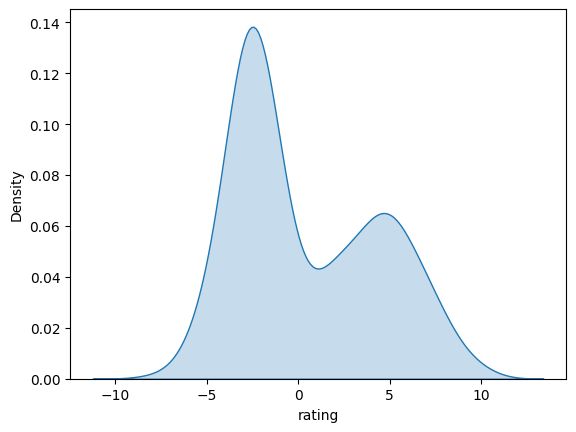

In [60]:
sns.kdeplot(x=residuals['rating'],fill=True);

In [61]:
loss_f=pd.DataFrame(history.history)

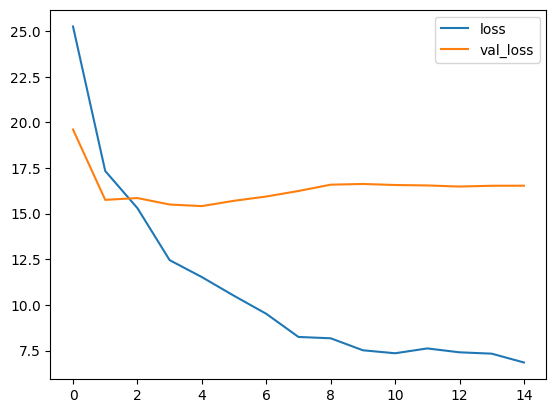

In [62]:
loss_f.plot();

TR = R2_score ekşili değer aldığı için automl aynı sonuç verecek mi diye baktım.

EN = Since R2_score has a certain value, I checked whether automl would give the same result.

In [63]:
#pip install pycaret

In [64]:
#from pycaret.regression import*

In [65]:
#setup(df,target='rating')

In [66]:
#best_model=compare_models()